# SOM_SpS Analysis

### This script is designed to explore the impact of prescribing SST while running the Los Alamos Sea Ice Model (CICE5) within the Community Earth System Model (CESM2), relative to using a slab ocean component.

#### Goals: 
1. Determine when each model run has reached equilibrium
2. Examine the reaction of the model to a longwave perturbation in both the prescribed SST(SpS) and slab ocean (SOM) cases
3. Investigate how a dynamic atmosphere might communicate the impact of prescribing SST over using a slab ocean

#### Setup: 

There will be 8 experimental cases centered around a slab ocean control run forced with daily initial conditions (dSOMcontrol). Four are dynamic ice + data atmosphere + SOM/SpS and four are dynamic ice + dynamic atmosphere + SOM/SpS. Within each group of four, the SOM/SpS pairs exist as either a control set or a longwave perturbed set.

The first part of this notebook will establish the equilibrium point that caps the spin up of each run. 

The second part will compare between SOM/SpS control and perturbed pairs for the data atmosphere cases.

The third part will do the same for the dynamic atmosphere cases.

The fourth will attempt to isolate the differences between the data and dynamic atmosphere scenarios. 

Files used live on NCAR's Cheyenne, in the glade directories of Cecilia Bitz (bitz), Vince Cooper (vcooper), and Molly Wieringa (mollyw)

#### In the words of vcooper, greetings! ...and beware.

### Preliminaries: set up the environment

In [10]:
%matplotlib inline

# math
import numpy as np
import numpy.ma as ma
import scipy as sc

# data
import xarray as xr
import pandas
import os
import os.path
import re
# import nc_time_axis
import glob
import csv

#plotting 
import matplotlib as mpl 
import matplotlib.path as mpath
from matplotlib import pyplot as plt 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import cmocean as cmo

import plotting_utils as plu

mpl.rcParams['font.size'] = 12

#### Import Data

In [2]:
# Paths

mmw_path = '/glade/scratch/mollyw/archive/'
mmw_work = '/glade/work/mollyw/SOM_SPS/'

vtc_path = '/glade/scratch/vcooper/archive/'
vtc_work = '/glade/work/vcooper/som2dom/'

timeseries_raw = '/ice/proc/tseries/month_1/'
timeseries_col = '/timeseries/'

# Parameters

mmw_cases = ['dSOMcontrol2',
            'dSOMperturb2',
           ]

vtc_cases = ['dSpScontrol',
             'dSpSperturb',
            ]

variables = ['aice',
             'fhocn',
             'flwdn',
             'fswabs',
             'fswdn',
             'hi',
             'hs',
             'qflux',
             'sss',
             'sst',
             'uocn',
             'vocn',
            ]

In [3]:
# Pull in cases 

ice = {}

for case in mmw_cases: 
    ice[case] = xr.open_dataset(mmw_work + timeseries_col + case + '.cice.h.tseries.nc')
        
# for case in vtc_cases:
#     ice[case] = xr.open_dataset(vtc_path + case + timeseries_raw + case + '.cice.h.tseries.nc')

In [13]:
ice

{'dSOMcontrol2': <xarray.Dataset>
 Dimensions:      (d2: 2, nc: 5, ni: 320, nj: 384, nkbio: 5, nkice: 8, nksnow: 3, nvertices: 4, time: 1200)
 Coordinates:
     TLON         (nj, ni) float32 ...
     TLAT         (nj, ni) float32 ...
     ULON         (nj, ni) float32 ...
     ULAT         (nj, ni) float32 ...
   * time         (time) object 0001-02-01 00:00:00 ... 0101-01-01 00:00:00
 Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkice, nksnow, nvertices
 Data variables:
     NCAT         (nc) float32 ...
     VGRDi        (nkice) float32 ...
     VGRDs        (nksnow) float32 ...
     VGRDb        (nkbio) float32 ...
     tmask        (nj, ni) float32 ...
     tarea        (nj, ni) float32 ...
     uarea        (nj, ni) float32 ...
     dxt          (nj, ni) float32 ...
     dyt          (nj, ni) float32 ...
     dxu          (nj, ni) float32 ...
     dyu          (nj, ni) float32 ...
     HTN          (nj, ni) float32 ...
     HTE          (nj, ni) float32 ...
     ANGLE   

### Part 1: Equilibrium 

Load volume or area data

In [5]:
from equilibrium import find_equilibrium
hemis       = ['nh', 'sh']
experiments = ['control2','perturb2']
metric = input("Volumes or areas?")

Volumes or areas? volumes


Calculate equilibrium

In [6]:
quantities     = {}
for experiment in experiments:
    quantities[experiment] = {}
    for hemi in hemis:
        if metric =='volumes':
            eq_file = '/icevol_d' + hemi + '_dSOM' + experiment + '.txt'
        elif metric =='areas':
            eq_file = '/icearea_d' + hemi + '_dSOM' + experiment + '.txt'
        quantities[experiment][hemi] = np.loadtxt(mmw_work + metric +'/' + experiment + eq_file)
        eq,percent,ind = find_equilibrium(quantities[experiment][hemi])
        quantities[experiment][hemi + '_eq'] = eq
        quantities[experiment][hemi + '_percent'] = percent
        quantities[experiment][hemi + '_ind'] = ind

Plot

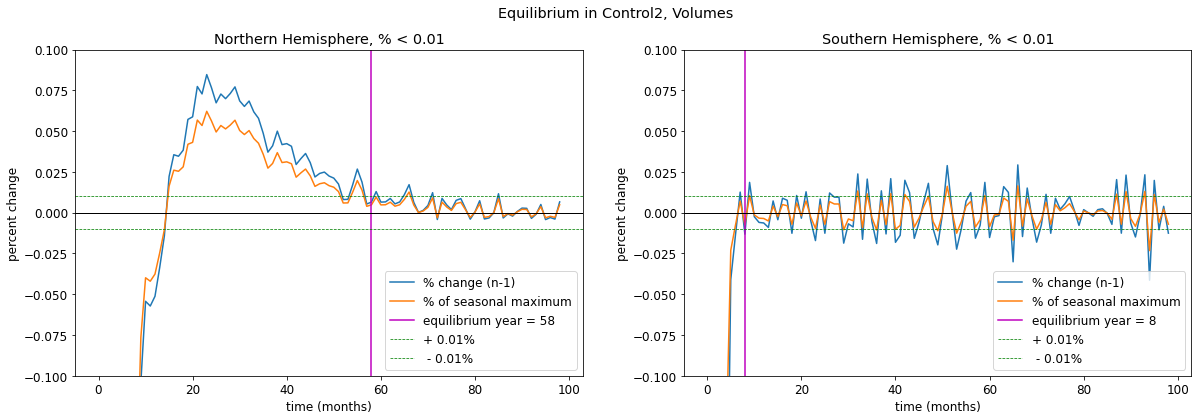

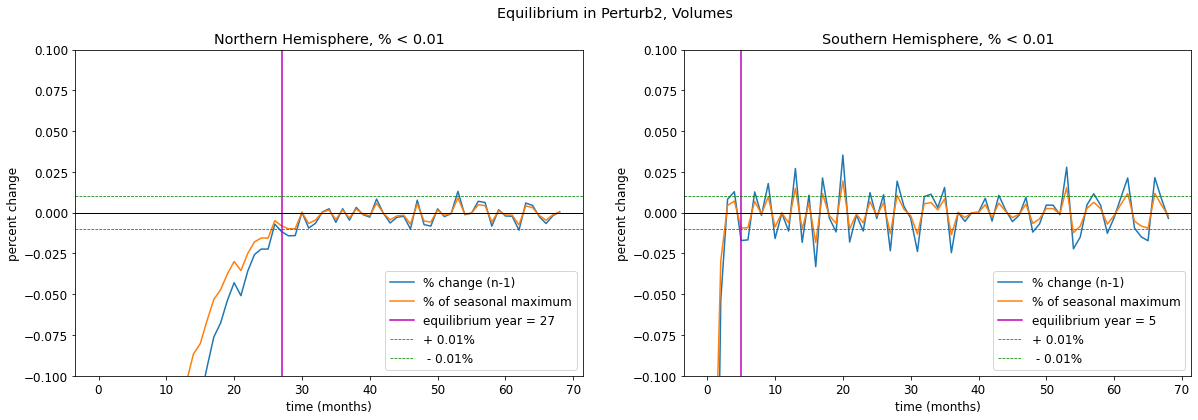

In [7]:
for experiment in experiments: 
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,6))

    axes[0].plot(quantities[experiment]['nh_eq'], label = "% change (n-1)")
    axes[0].plot(quantities[experiment]['nh_percent'], label = "% of seasonal maximum")
    axes[0].axvline(quantities[experiment]['nh_ind'], c = 'm', label = "equilibrium year = " + str(quantities[experiment]['nh_ind']))
    axes[0].axhline(0.01, ls = '--', c = 'g', lw = 0.75, label='+ 0.01%')
    axes[0].axhline(0, ls = '-', c = 'k', lw = 1.00)
    axes[0].axhline(-0.01, ls = '--', c = 'g', lw = 0.75, label=' - 0.01%')
    axes[0].legend(loc = 'lower right')
    axes[0].set_title("Northern Hemisphere, % < 0.01")
    axes[0].set_ylim([-0.1, 0.1])
#     axes[0].set_xlim([12,len(np.flip(volumes[experiment]['nh_eq'],0))])
    axes[0].set_ylabel('percent change')
    axes[0].set_xlabel('time (months)')

    axes[1].plot(quantities[experiment]['sh_eq'], label = "% change (n-1)")
    axes[1].plot(quantities[experiment]['sh_percent'], label = "% of seasonal maximum")
    axes[1].axvline(quantities[experiment]['sh_ind'], c = 'm', label = "equilibrium year = " + str(quantities[experiment]['sh_ind']))
    axes[1].axhline(0.01, ls = '--', c = 'g', lw = 0.75, label='+ 0.01%')
    axes[1].axhline(0, ls = '-', c = 'k', lw = 1.00)
    axes[1].axhline(-0.01, ls = '--', c = 'g', lw = 0.75, label=' - 0.01%')
    axes[1].legend(loc = 'lower right')
    axes[1].set_title("Southern Hemisphere, % < 0.01")
    axes[1].set_ylim([-0.1, 0.1])
    #axes[1].set_xlim([12,len(np.flip(volumes[experiment]['nh_eq'],0))])
    axes[1].set_ylabel('percent change')
    axes[1].set_xlabel('time (months)')

    plt.suptitle('Equilibrium in ' + str.capitalize(experiment) + ', ' + metric.capitalize())

### Part 2: dSOM and dSpS

The Polar Stereo code is plotting empty values for me (mmw), even with vtc's grid hack. I have double checked and matched packages, tested different dSOMcontrol and dSpScontrol files from both mmw and vtc, and note that the colorbar scales are appropriate for values we would expect for both the normal concentration and the difference plots. I am not quite sure what to do from here, but will keep investigating. Perhaps this is something to do with my ncar_pylib configuration...

#### SOM: Control vs perturbation

In [8]:
dSOMcontrol = ice['dSOMcontrol2']
dSOMperturb = ice['dSOMperturb2']

trimmed_vars = ['aice',
                'fhocn',
                'hi',
                'hs',
                'qflux',
                'sss',
                'sst',
                'uocn',
                'vocn',
               ]

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


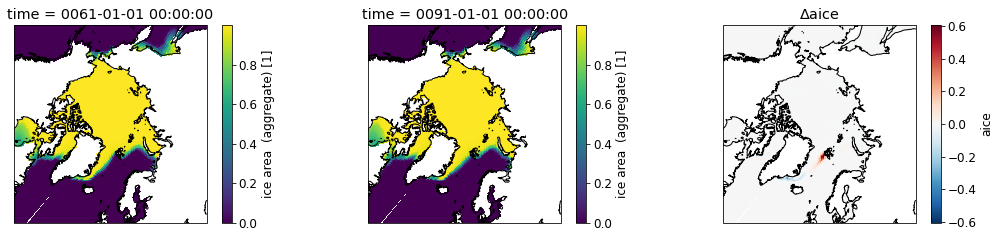

<Figure size 432x288 with 0 Axes>

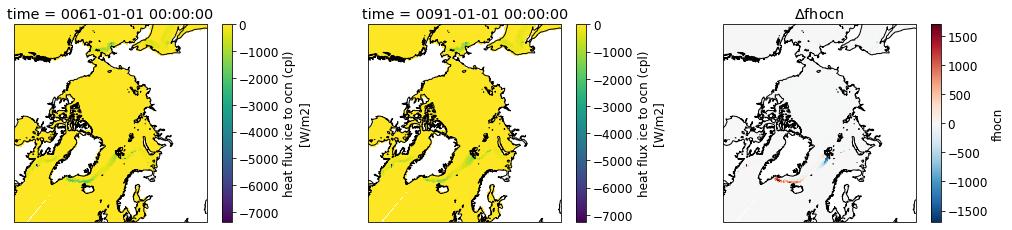

<Figure size 432x288 with 0 Axes>

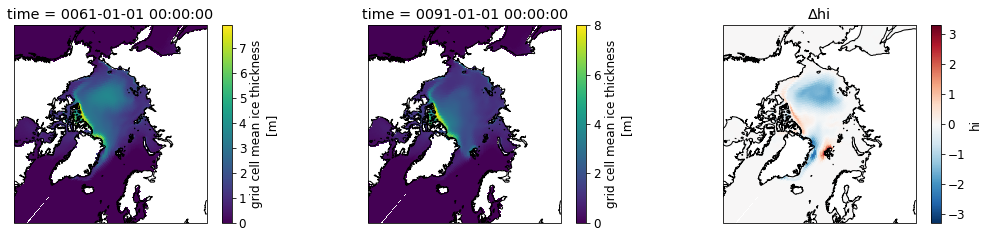

<Figure size 432x288 with 0 Axes>

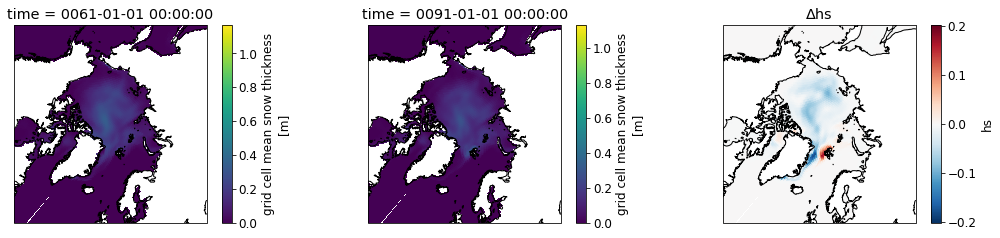

<Figure size 432x288 with 0 Axes>

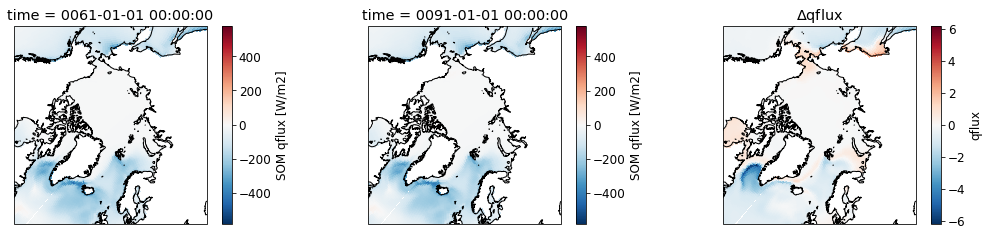

<Figure size 432x288 with 0 Axes>

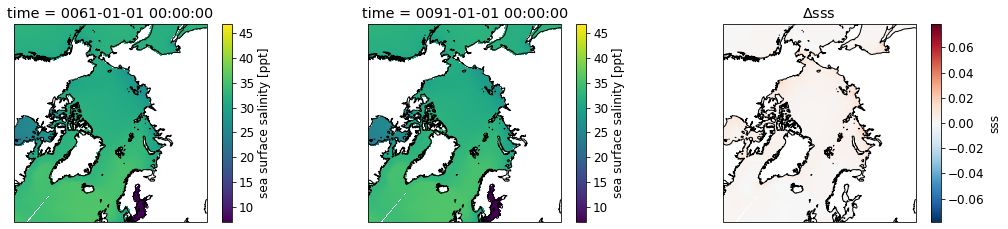

<Figure size 432x288 with 0 Axes>

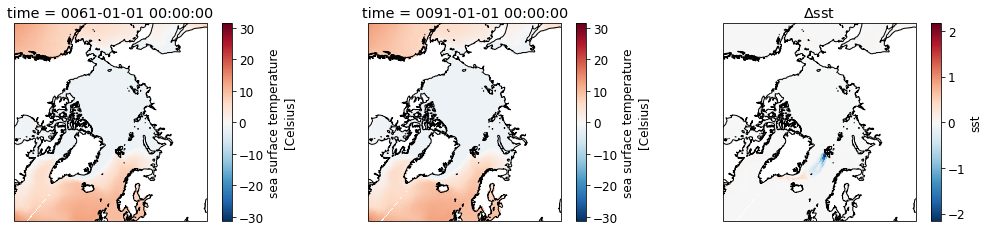

<Figure size 432x288 with 0 Axes>

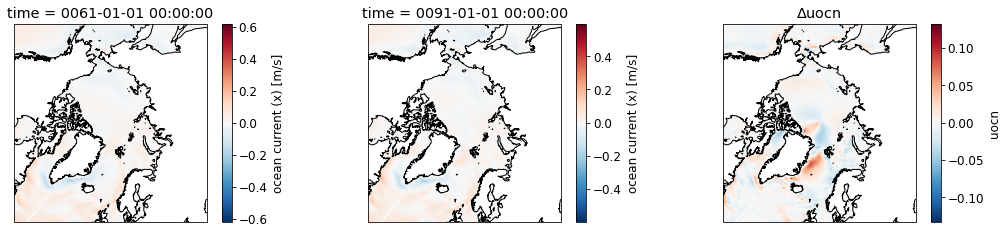

<Figure size 432x288 with 0 Axes>

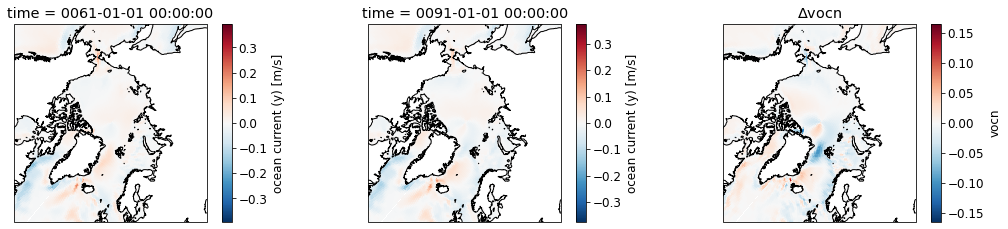

<Figure size 432x288 with 0 Axes>

In [18]:
plu.plot_NH_differences(dSOMcontrol, dSOMperturb, [60,30], trimmed_vars)

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


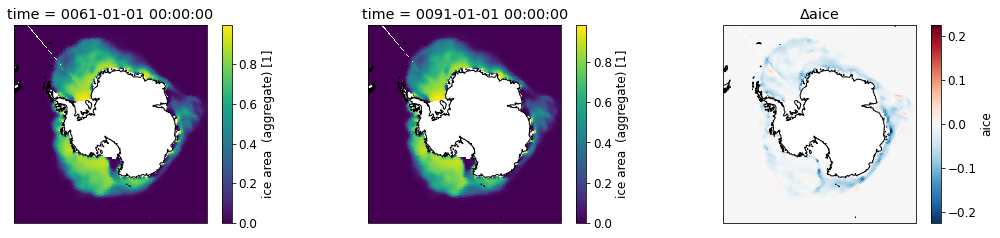

<Figure size 432x288 with 0 Axes>

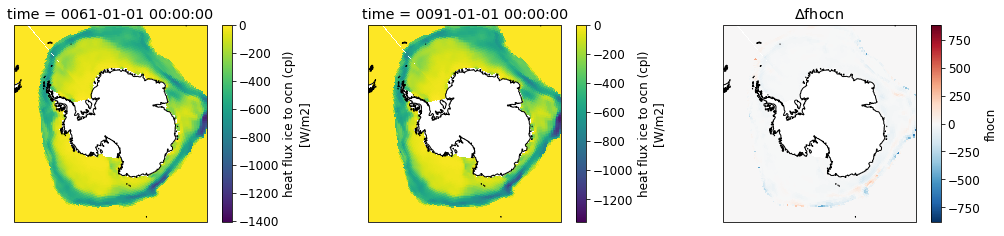

<Figure size 432x288 with 0 Axes>

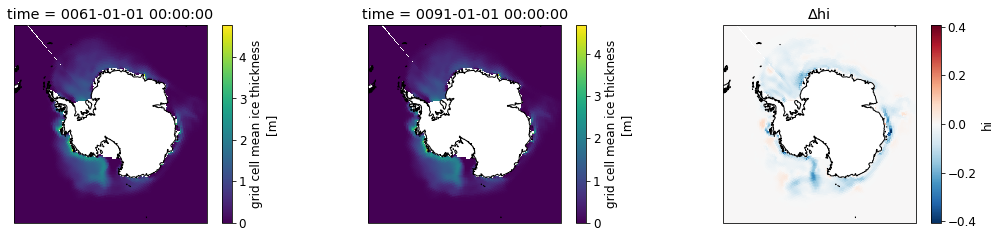

<Figure size 432x288 with 0 Axes>

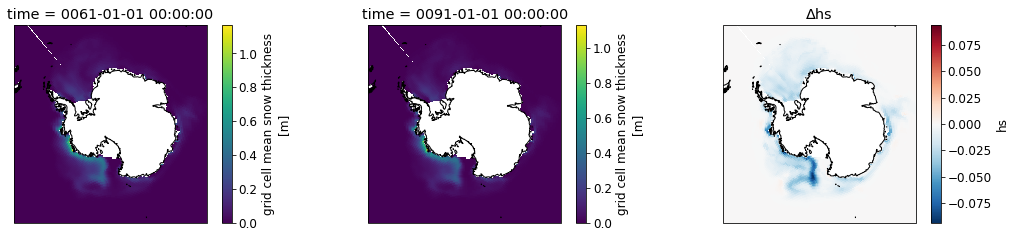

<Figure size 432x288 with 0 Axes>

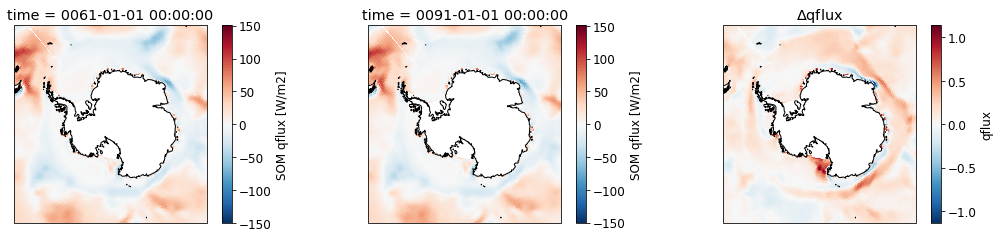

<Figure size 432x288 with 0 Axes>

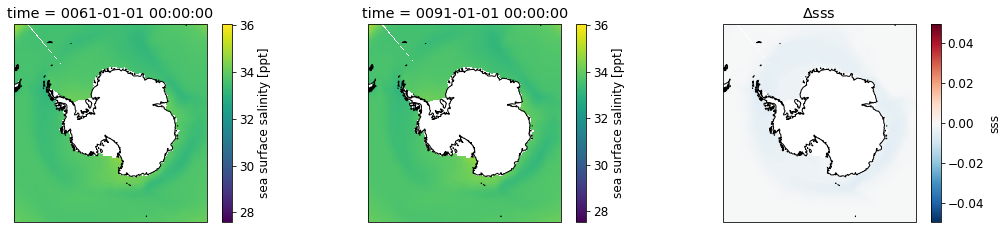

<Figure size 432x288 with 0 Axes>

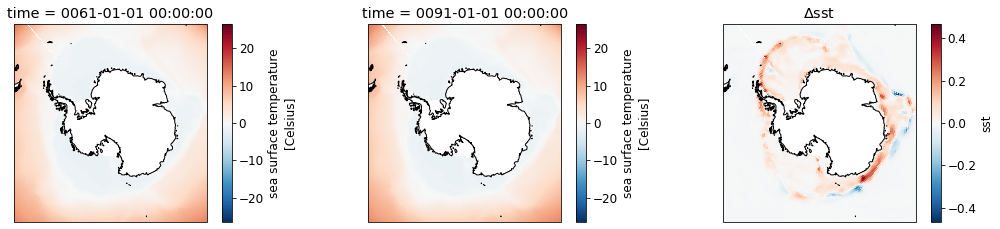

<Figure size 432x288 with 0 Axes>

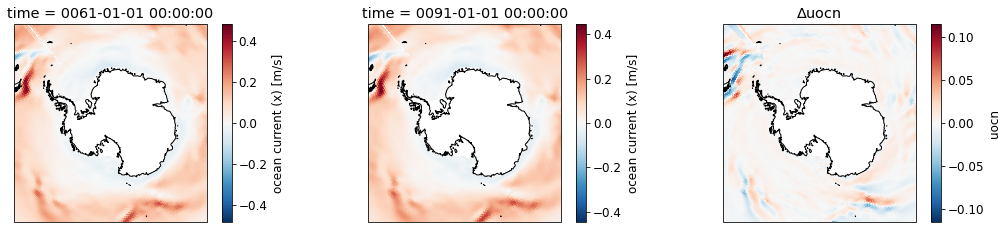

<Figure size 432x288 with 0 Axes>

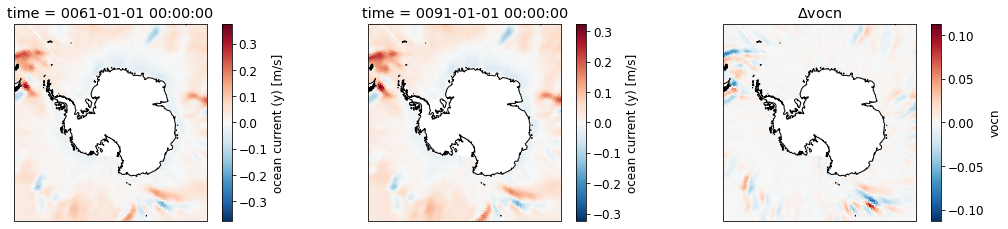

<Figure size 432x288 with 0 Axes>

In [11]:
plu.plot_SH_differences(dSOMcontrol, dSOMperturb, [60,30], trimmed_vars)

#### SpS: Control vs perturbation

In [ ]:
#to be run once we have nice timeseries to load in at the top
dSpScontrol = ice['dSpScontrol']
dSpSperturb = ice['dSpSperturb']

plu.plot_NH_differences(dSpScontrol, dSpSperturb, [yr_eq_cntrl, yr_eq_pert], trimmed_vars)
plu.plot_SH_differences(dSpScontrol, dSpSperturb, [yr_eq_cntrl, yr_eq_pert], trimmed_vars)

#### SOM vs SpS

In [ ]:
even_more_trimmed_vars=['aice',
                        'hi',
                        'sst',
                        'qflux',
                       ]

plu.plot_NH_differences(dSOMcontrol, dSpScontrol, [60, yr_eq_pert], even_more_trimmed_vars)
plu.plot_SH_differences(dSOMcontrol, dSpScontrol, [60, yr_eq_pert], even_more_trimmed_vars)

In [ ]:
plu.plot_NH_differences(dSOMperturb, dSpSperturb, [90, yr_eq_pert], even_more_trimmed_vars)
plu.plot_SH_differences(dSOMperturb, dSpSperturb, [90, yr_eq_pert], even_more_trimmed_vars)

### Part 3: atmSOM and atm SpS

### Part 4: AGCM vs DATM

## Old Code

Original data loading scheme

In [ ]:
## NOTE: Edit this to read full timeseries generated on cheyenne, rather than individual history files! mmw,05/22 ##

mmw_path = '/glade/scratch/mollyw/archive/' #/SOMcontrol/ice/hist/'
cmb_path = '/glade/scratch/bitz/archive/' #/SOMcontrol/ice/hist/'
vtc_path = '/glade/scratch/vcooper/archive/'

paths= [mmw_path,
       cmb_path,
       vtc_path]

cases = ['SOMcontrol',
         'dSOMcontrol',
         'dSpScontrol',
         'dSOMperturb',
         'dSpSperturb'
        ]

runtime = {'SOMcontrol' : (1,41),
           'dSOMcontrol': (1,100),
           'dSpScontrol': (61,130),
           'dSOMperturb': (61,120),
           'dSpSperturb': (61,100)
          }

In [ ]:
fp={} #empty dictionary for file paths
ice={} #empty dictionary for datasets

for path in paths:
    for case in cases:
        address = path + case + '/ice/hist/'
        if address == vtc_path + 'SOMcontrol' + '/ice/hist/':
            print("skipped vtc SOMcontrol")
        elif os.path.exists(address) == True:
            ice[case]= {}
            if runtime[case][0] <= 10:
                for x in range(1,10):
                    fp["file000{0}_03".format(x)]= address + case + '.cice.h.000{0}-03.nc'.format(x)
                    fp["file000{0}_09".format(x)]= address + case + '.cice.h.000{0}-09.nc'.format(x)
                
                    ice[case][case + "_000{0}_03".format(x)] = xr.open_dataset(fp["file000{0}_03".format(x)])
                    ice[case][case + "_000{0}_09".format(x)] = xr.open_dataset(fp["file000{0}_09".format(x)])
                    
                if runtime[case][1] < 100:
                    for x in range(10,runtime[case][1] + 1):
                        fp["file00{00}_03".format(x)]= address + case + '.cice.h.00{00}-03.nc'.format(x)
                        fp["file00{00}_09".format(x)]= address + case + '.cice.h.00{00}-09.nc'.format(x)
                
                        ice[case][case + "_00{00}_03".format(x)] = xr.open_dataset(fp["file00{00}_03".format(x)])
                        ice[case][case + "_00{00}_09".format(x)] = xr.open_dataset(fp["file00{00}_09".format(x)])
                else:
                    for x in range(10,100):
                        fp["file00{00}_03".format(x)]= address + case + '.cice.h.00{00}-03.nc'.format(x)
                        fp["file00{00}_09".format(x)]= address + case + '.cice.h.00{00}-09.nc'.format(x)
                
                        ice[case][case + "_00{00}_03".format(x)] = xr.open_dataset(fp["file00{00}_03".format(x)])
                        ice[case][case + "_00{00}_09".format(x)] = xr.open_dataset(fp["file00{00}_09".format(x)])
                
                    for x in range(100,runtime[case][1] + 1): 
                        fp["file0{000}_03".format(x)]= address + case + '.cice.h.0{000}-03.nc'.format(x)
                        fp["file0{000}_09".format(x)]= address + case + '.cice.h.0{000}-09.nc'.format(x)
            
                        ice[case][case + "_0{000}_03".format(x)] = xr.open_dataset(fp["file0{000}_03".format(x)])
                        ice[case][case + "_0{000}_09".format(x)] = xr.open_dataset(fp["file0{000}_09".format(x)])
                    
            elif runtime[case][0] > 10 and runtime[case][0] < 100:
                for x in range(runtime[case][0],100):
                    fp["file00{00}_03".format(x)]= address + case + '.cice.h.00{00}-03.nc'.format(x)
                    fp["file00{00}_09".format(x)]= address + case + '.cice.h.00{00}-09.nc'.format(x)
                
                    ice[case][case + "_00{00}_03".format(x)] = xr.open_dataset(fp["file00{00}_03".format(x)])
                    ice[case][case + "_00{00}_09".format(x)] = xr.open_dataset(fp["file00{00}_09".format(x)])
                
                for x in range(100,runtime[case][1]+1): 
                    fp["file0{000}_03".format(x)]= address + case + '.cice.h.0{000}-03.nc'.format(x)
                    fp["file0{000}_09".format(x)]= address + case + '.cice.h.0{000}-09.nc'.format(x)
                
                    ice[case][case + "_0{000}_03".format(x)] = xr.open_dataset(fp["file0{000}_03".format(x)])
                    ice[case][case + "_0{000}_09".format(x)] = xr.open_dataset(fp["file0{000}_09".format(x)])
            
            else:
                for x in range(100, runtime[case][1] + 1):
                    fp["file0{000}_03".format(x)]= address + case + '.cice.h.0{000}-03.nc'.format(x)
                    fp["file0{000}_09".format(x)]= address + case + '.cice.h.0{000}-09.nc'.format(x)
                
                    ice[case][case + "_0{000}_03".format(x)] = xr.open_dataset(fp["file0{000}_03".format(x)])
                    ice[case][case + "_0{000}_09".format(x)] = xr.open_dataset(fp["file0{000}_09".format(x)])
                    
        else: 
            print(path + case + ' does not exist')
        
        

Old equilibrium cells

In [ ]:
NHlist = []
SHlist = []

## USE THIS TO SMOOTH
#annualmean = icevol_nh_dSOMcontrol.reshape(12,icevol_nh_dSOMcontrol.size//12,order='F').mean(axis=0)
#annualmax = icevol_nh_dSOMcontrol.reshape(12,icevol_nh_dSOMcontrol.size//12,order='F').max(axis=0)
## 


for experiment in experiments:
    for hemisphere in hemispheres:
        
        annualmean = volumes[experiment][hemisphere].reshape(12,volumes[experiment][hemisphere].size//12,order='F').mean(axis=0)
        annualmax = volumes[experiment][hemisphere].reshape(12,volumes[experiment][hemisphere].size//12,order='F').max(axis=0)
        
        eq = (annualmean[1:]/annualmean[0:-1]-1)*100
        percent = (annualmean[1:]-annualmean[0:-1])/annualmax[1:]*100
        
        # There is probably a better way to do this smoothing with a python package; come back to this later
        '''Hlist = []
        for i in range(6,(len(volumes[experiment][hemisphere])-5)):
            Hlist.append(sum(volumes[experiment][hemisphere][(i-6):(i+6)]/12))
            
        H = np.asarray(Hlist)

        # Calculate the equilibrium point
        timefor = np.arange(0, len(H))
        timeback = np.flip(timefor,0)

        seasonal = volumes[experiment][hemisphere]
        
        eq = []
        percent = []

        for x in timeback:
            eq.append((H[x] - H[x-12])/H[x]*100)
            seas_max = (seasonal[0+11*x/12:11+11*x/12].max())
            percent.append(((H[x] - H[x-12])/(seas_max))*100)'''
            
            
        volumes[experiment][hemisphere + '_eq'] = eq
        volumes[experiment][hemisphere + '_percent'] = percent
            

In [ ]:
x = [1,2,3]
X= np.where(x==3)

In [ ]:
X